___
# Projeto 3 - CD
___

## Regressão logística que agrupa músicas com diferentes tipos de tons e de notas musicais, relacionando com o quão dançável é a música.

    Imagine que você é um músico e quer compor uma música, porém quer que ela seja calma e que esteja no Spotify, qual a probabilidade de você usar o tom menor e qual nota provavelmente você usaria? 
    O objetivo desse projeto é responder esta pergunta prevendo qual seria a decisão que você, provavelmente, tomaria nesta situação. Para isso, devemos utilizar a regressão logística, pois estamos relacionando uma variável categórica com uma contínua. Ou seja, estamos relacionando as notas musicais e o tom (juntamente a elas) com o quão dançável é a música, fazendo uma comparação, também, com o quão energética é a música.

Exemplo de aplicação da técnica: https://www.kaggle.com/noemir/dimension-reduction-of-music-pref-in-progress/comments 

**Nomes das integrantes:**
Rebeca Moreno,
Giulia Passarelli e
Carla Kim

## Parte 1: Dicionário dos Dados

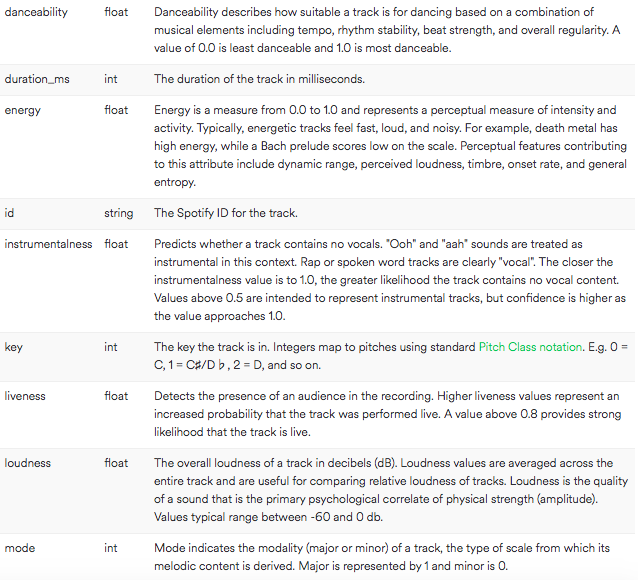

In [44]:
from IPython.display import Image
Image(filename=('/Users/RebecaMoreno/Desktop/dic.png'))

In [45]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import expon
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D

In [46]:
#lendo a planilha de dados
sptdata = pd.read_csv("data.csv")

#ajustando a quantidade de termos que precisamos usar
spotdata = sptdata[0:500]
spotdatatreina = sptdata[500:1000]
spotdata['loudness'].describe()

count    500.000000
mean      -7.334266
std        2.734389
min      -20.815000
25%       -8.744250
50%       -6.991500
75%       -5.379000
max       -0.307000
Name: loudness, dtype: float64

## Parte 2: Discretizando dados

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

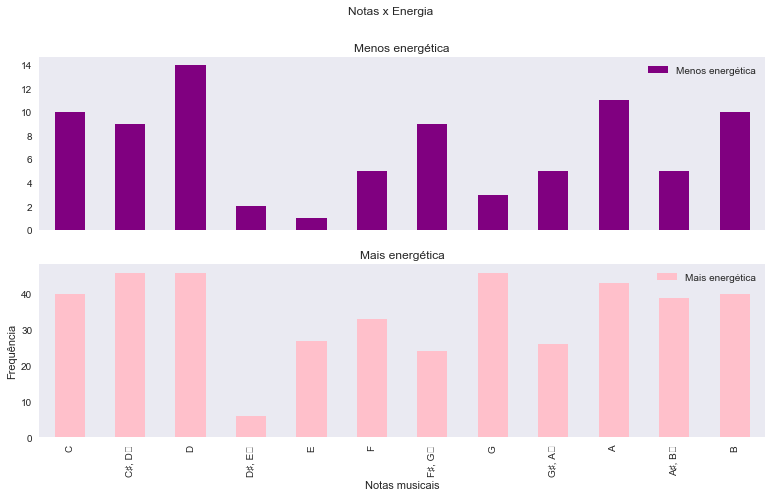

In [47]:
#criando uma nova coluna somente para o KEY CATEGÓRICO, ou seja, só com as notas (strings)
spotdata['notakey'] = spotdata.key
spotdata['notakey'] = spotdata['notakey'].astype('category')
l = ['C','C♯, D♭','D','D♯, E♭','E','F','F♯, G♭','G','G♯, A♭','A','A♯, B♭','B']
spotdata['notakey'].cat.categories = (l)

#criando uma nova coluna somente para o ENERGY CATEGÓRICO, ou seja, só com dois grupos (strings)
spotdata['energyy'] = spotdata['energy']
#filtrando...
spotdata.energyy[(spotdata.energyy >= 0) & (spotdata.energyy < 0.5)] = [0]
spotdata.energyy[(spotdata.energyy >= 0.5) & (spotdata.energyy < 1)] = [1]
spotdata.energyy = spotdata.energyy.astype('category')
spotdata.energyy.cat.categories = (['Menos energética','Mais energética'])

#criando uma nova coluna para energy que não esteja dividida em binários
spotdata['energynaobin'] = spotdata['energy']

#criando uma nova coluna para liveness que não esteja dividida em binários
spotdata['livenesS'] = spotdata['liveness']

#criando uma nova coluna para loudness que não esteja dividida em binários
spotdata['loudnesS'] = spotdata['loudness']

#criando uma nova coluna somente para o MODE CATEGÓRICO, ou seja, só com os dois grupos (strings)
df = pd.DataFrame()
spotdata['tom'] = spotdata['mode']
spotdata['tom'] = spotdata.tom.astype('category')
spotdata.tom.cat.categories = (['Menor','Maior'])

#tabela de notas por energy
NotaEnergy = pd.crosstab(spotdata.notakey,spotdata.energyy, colnames=['Grau de energia'],rownames=['Notas musicais'])
NotaEnergy.plot(kind = 'bar',title = 'Notas x Energia',figsize=(13,7),color = ('purple','pink'),grid=False,subplots=True)
plt.ylabel('Frequência')
plt.show()

    Neste gráfico, podemos observar que, nesta lista de 500 músicas, são tocadas mais músicas energéticas do que o contrário, pois a quantidade de dados com a cor rosa é maior que a da cor roxa. Lenvando isso para o nosso contexto, você teria menor possibilidade de ser aceito, fazendo uma música mais calma (menos energética). No entanto, esta não é descartada.
    Observamos também que a nota C#/D, por exemplo, tem uma tendência de ser tocada em músicas mais energéticas, enquanto que a nota mais frequente em músicas depressivas é a D. Portanto, no seu caso, para você fazer uma música menos elétrica, sendo ela aceita pelo Spotify, a probabilidade que se use a nota D é alta, uma vez que sua frenquência em músicas calmas é alta, enquanto que a nota E é muito pouco provável, por exemplo.

    Para analisar o comportamento do loudness com os nossos dados, devemos primeiro entender realmente o que significa, pois somente a explicação do dicionário não nos ajudou. 
    Loudness é o volume ou nível de audibilidade do som, também chamado de sonância e refere-se à sensação psico-acústica percebida pelo ouvinte, que depende da frequência e da intensidade sonora da música.

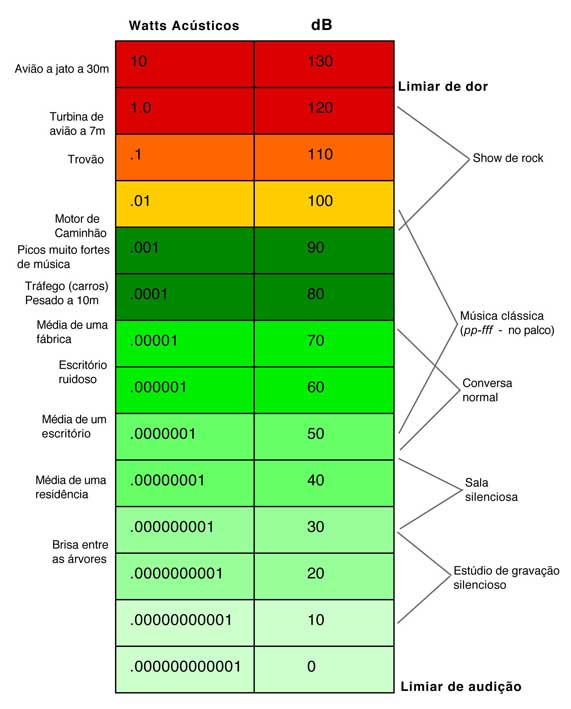

In [48]:
Image(filename=('/Users/RebecaMoreno/Desktop/niveis_intensidade.png'))

In [49]:
#tabela de  frequência das notas em cada tipo de tom
ut2 = pd.crosstab(spotdata.notakey,spotdata.tom, colnames=['Tom'], rownames=['Notas Musicais'], margins=True)
ut2

Tom,Menor,Maior,All
Notas Musicais,,,
C,10,40,50
"C♯, D♭",17,38,55
D,13,47,60
"D♯, E♭",3,5,8
E,18,10,28
F,25,13,38
"F♯, G♭",14,19,33
G,11,38,49
"G♯, A♭",10,21,31


    Nesta tabela, vemos, não só a frequência de cada nota dentro das 500 músicas, como também a quantidade de vezes que esta nota foi usada em músicas com tom maior e menor. 
    Nela, vemos que, em músicas com tom maior, são frequentemente usadas as notas: D, C e C#/D ou G. 
    Em contrapartida, em músicas com tom menor, são frequentemente usadas as notas: B, A#/B e F ou A.   
    

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

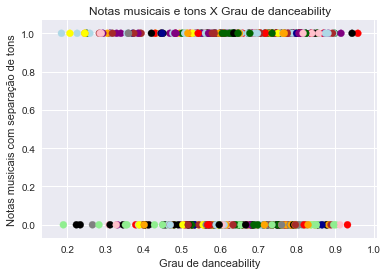

In [50]:
#para o treinamento do computador dos 100 primeiros termos
spotdata['mode12key'] = spotdata['mode']*12 + spotdata['key']
spotdata['mode12key'] = np.where(spotdata.mode12key >= spotdata['mode12key'].mean(), 1, 0)
#para o teste dos novos termos de 100 a 200
spotdata['mode12keytreina'] = spotdatatreina['mode']*12 + spotdatatreina['key']
spotdata['mode12keytreina'] = np.where(spotdata.mode12keytreina >= spotdata['mode12keytreina'].mean(), 1, 0)

spotdata["notas"] = spotdata["key"]    
spotdata['notas'] = spotdata['notas'].map({0: "C", 1: "C♯, D♭", 2: "D", 3: "D♯, E♭", 4: "E", 5: "F", 6: "F♯, G♭", 7: "G", 8: "G♯, A♭", 9: "A", 10: "A♯, B♭", 11: "B"})

#plot do gráfico 
fig, ax = plt.subplots()
colors = {'C':'lightgreen', 'C♯, D♭':'darkgreen', 'D':'lightblue', 'D♯, E♭':'darkblue', 'E':'yellow', 'F':'orange', 'F♯, G♭':'pink', 'G':'purple', 'G♯, A♭':'red', 'A':'brown', 'A♯, B♭':'gray', 'B':'black'}
ax.scatter(spotdata['danceability'], spotdata['mode12key'], c=spotdata['notas'].apply(lambda x: colors[x]))
plt.title('Notas musicais e tons X Grau de danceability')
plt.ylabel('Notas musicais com separação de tons')
plt.xlabel('Grau de danceability')
plt.show()

## Parte 3: Gráfico da regressão logística

In [51]:
# fit a logistic regression model and store the class predictions
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
feature_cols = ['danceability']
X = spotdata[feature_cols]
y = spotdata['mode12key']
logreg.fit(X, y)
spotdata['mode12key_pred_class'] = logreg.predict(X)

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


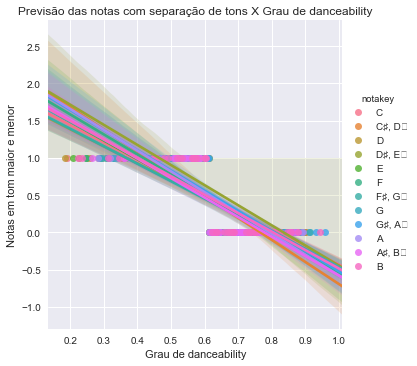

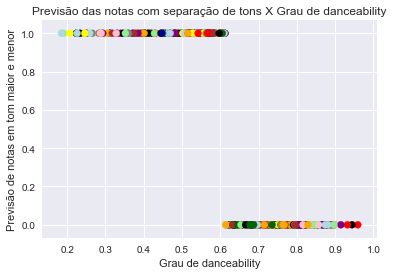

In [52]:
g = sns.lmplot(x="danceability", y="mode12key_pred_class", hue="notakey", data=spotdata,size=5)
plt.title('Previsão das notas com separação de tons X Grau de danceability')
plt.xlabel('Grau de danceability')
plt.ylabel('Notas em tom maior e menor')
#gráfico dos dois grupos de tons (maior e menor) das notas de cada música por danceability
fig, ax = plt.subplots(1)
ax.scatter(spotdata['danceability'], spotdata['mode12key_pred_class'], c=spotdata['notas'].apply(lambda x: colors[x]))
plt.title('Previsão das notas com separação de tons X Grau de danceability')
plt.xlabel('Grau de danceability')
plt.ylabel('Previsão de notas em tom maior e menor')
plt.show()

    Os dois gráficos indicam uma previsão das notas e dos tons (juntamente a elas) com relação ao "danceability". De forma que, no primeiro gráfico, são feitas regressões logísticas para cada nota musical, entretanto não é possível enxergar de maneira clara. Por isso, construímos o segundo gráfico, o qual tem a mesma finalidade do primeiro, porém sem as retas de regressão. Nele, observamos que músicas menos dançantes possuem maior probabilidade de utilizarem tons maiores.

    Para enxergarmos claramente as regressões do primeiro gráfico, construímos 12 gráficos, em que cada um representa a regressão logística de uma determinada nota musical.

GRÁFICOS DE REGRESSÃO LOGÍSTICA DE CADA NOTA POR GRAU DE DANCEABILITY


Regressão logística das notas com separação de tons X Grau de danceability


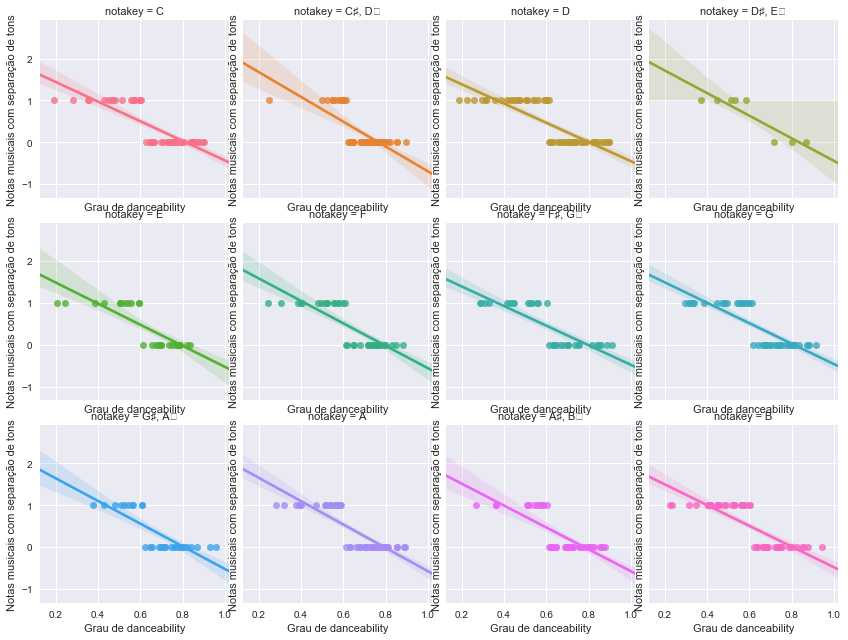

In [53]:
#gráfico da regressão logística das notas de cada música baseada em danceability
print('GRÁFICOS DE REGRESSÃO LOGÍSTICA DE CADA NOTA POR GRAU DE DANCEABILITY\n\n')
print('Regressão logística das notas com separação de tons X Grau de danceability')
a = sns.lmplot(x="danceability", y="mode12key_pred_class", col="notakey", hue="notakey",data=spotdata, col_wrap=4, size=3)
a.set(xlabel = "Grau de danceability", ylabel = "Notas musicais com separação de tons")
plt.show()

    A reta representa a regressão logística da nota musical juntamente com a diferença no tipo de tom por danceability. A "mancha" mais clara que há em algumas regressões nos diz que, como temos poucos pontos do gráfico, há uma margem de erro, representada por essa "mancha".
    Conseguimos ver, também, a quantidade de cada nota em tom maior e menor por cada grau de danceability.

## Parte 4: Gráfico de probabilidade e exemplos

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


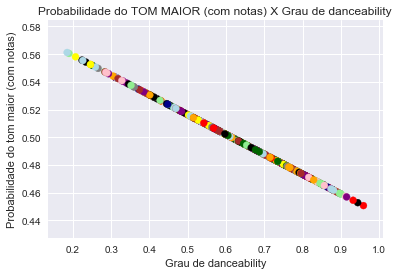

In [54]:
#gráfico da probabilidade por danceability
spotdata['mode12key_pred_prob'] = logreg.predict_proba(X)[:, 1]

fig, ax = plt.subplots()
ax.scatter(spotdata['danceability'], spotdata['mode12key_pred_prob'], c=spotdata['notas'].apply(lambda x: colors[x]))
plt.title('Probabilidade do TOM MAIOR (com notas) X Grau de danceability')
plt.xlabel('Grau de danceability')
plt.ylabel('Probabilidade do tom maior (com notas)')
plt.show()

    O gráfico de probabilidade do tom maior acima comprova que, para dançabilidades baixas, é mais provável que o tom da música seja mais alto e vice-versa.

In [55]:
# alguns exemplos de previsões
print('Exemplos de Probabilidades\n')
print('   Tom menor  |  Tom maior')

grau_de_danceability1 = 0.2
grau_de_danceability2 = 0.5
grau_de_danceability3 = 0.8

print(logreg.predict_proba(grau_de_danceability1))
print(logreg.predict_proba(grau_de_danceability2))
print(logreg.predict_proba(grau_de_danceability3))

Exemplos de Probabilidades

   Tom menor  |  Tom maior
[[ 0.44092688  0.55907312]]
[[ 0.48370633  0.51629367]]
[[ 0.52672592  0.47327408]]


    A primeira coluna diz respeito ao grupo de notas com o tom menor, mostrando a exata chance de se ter, por exemplo, um grau de danceability de 0.2 com o tom menor. Neste caso, a probabilidade de se ter tal danceability com tom menor é de 44.092688 %. Enquanto que, na segunda coluna, temos as mesmas informações, porém referentes ao grupo de notas com tom maior.
    Como, no caso, queremos achar a probabilidade de usarmos tom maior em uma música calma, ou seja, com um grau de danceability baixo, podemos assumir um limite de 0 a 0.5 deste grau para acharmos tal probabilidade.

In [56]:
grau_de_danceability4 = 0
grau_de_danceability5 = 0.25
grau_de_danceability6 = 0.5

print('   Tom menor  |  Tom maior')
print(logreg.predict_proba(grau_de_danceability4))
print(logreg.predict_proba(grau_de_danceability5))
print(logreg.predict_proba(grau_de_danceability6))

   Tom menor  |  Tom maior
[[ 0.41284817  0.58715183]]
[[ 0.44801339  0.55198661]]
[[ 0.48370633  0.51629367]]


    Portanto, a probabilidade de se usar tom maior em uma música calma (grau de danceability de 0 a 0.5) é de 41.284817 % até 48.370633 %. Vemos que, quanto menos dançante é a música (quanto mais próximo de 0 é o grau de danceability), maior é a probabilidade de se usar o tom maior nas músicas. 
    Assumamos que 0.25 seja o exato grau de danceability que você deseja para fazer sua composição. Neste caso, sabemos que a probabilidade de se usar o tom menor é 44.801339 %. 
    Sendo assim, qual seria a probabilidade de você usar a nota D, por exemplo?
    Para isso, vamos ter que ver quais as notas mais próximas deste danceability (ou de um genérico), sejam elas referente ao lado direito do gráfico ou ao esquerdo.

In [57]:
#DIREITA: para dizer quais as notas à direita mais próximas ao nosso referecial dance, tivemos que usar a função
#reversed() do python, pois, assim, temos as notas mais próximas do dance escolhido.

#o grau de danceability escolhido para se achar a nota mais provável é o de 0.25 
#(assumido anteriormente como o grau desejado na composição)
dance = 0.25
dances_ao_redor = []
notas_ao_redor = []
dances_ao_redor2 = []
notas_ao_redor2 = []
d = np.arange(0,0.15,0.001)

for i in range(len(spotdata)):
    for k in range(len(d)):
        #para o lado direito (dance+d[k])
        if dance+d[k] == spotdata['danceability'][i]:
            #cada danceability de i adicionado tem sua respectiva nota adicionada em notas_ao_redor, ou seja,
            #o primeiro termo da lista dances_ao_redor está para o primeiro termo da lista notas_ao_redor etc.
            dances_ao_redor.append(spotdata['danceability'][i])
            notas_ao_redor.append(spotdata['notakey'][i])
            
        if spotdata['danceability'][i] not in dances_ao_redor:
            #para o lado esquerdo (dance-d[k])
            if dance-d[k] == spotdata['danceability'][i]:
                dances_ao_redor2.append(spotdata['danceability'][i])
                notas_ao_redor2.append(spotdata['notakey'][i])
a = dances_ao_redor
b = notas_ao_redor
Z = [x for _,x in sorted(zip(a,b))]
print('Das mais próximas até as menos próximas, Z é a lista de notas próximas ao grau de danceability escolhido do lado direito do gráfico:')
print(Z)
print('\n')

#ESQUERDA: para dizer quais as notas à esquerda mais próximas ao nosso referecial dance, tivemos que usar a função
#reversed() do python, pois, assim, temos as notas mais próximas do dance escolhido.

a2 = dances_ao_redor2
b2 = notas_ao_redor2
Z2 = [x for _,x in sorted(zip(a2,b2))]
Z3 = []
for i in reversed(Z2):
    Z3.append(i)
print('Das mais próximas até as menos próximas, Z3 é a lista de notas próximas ao grau de danceability escolhido do lado esquerdo do gráfico:')
print(Z3)
print('\n')

#JUNTANDO PARA MONTAR A FREQUÊNCIA
print('Das mais próximas até as menos próximas, lista_de_notas_proximas é a junção das duas listas de notas explicadas anteriormente:')
lista_de_notas_proximas = Z+Z3
print(lista_de_notas_proximas)
print('\n')

#fazendo como se fosse o value_counts(), porém usando 
#o tipo set (conjunto) p/ eliminar os elementos repetidos e colocando tudo num "dict comprehension"
print('A frequência de cada nota em um espaço de danceability que vai de (0.1) até (0.4):')
diccounts = {x:lista_de_notas_proximas.count(x) for x in set(lista_de_notas_proximas)}
print(diccounts)

Das mais próximas até as menos próximas, Z é a lista de notas próximas ao grau de danceability escolhido do lado direito do gráfico:
['C♯, D♭', 'D', 'A♯, B♭', 'C', 'F♯, G♭', 'F♯, G♭', 'G', 'D', 'F', 'F♯, G♭', 'B', 'G', 'G', 'D', 'D', 'A', 'G', 'A♯, B♭', 'A♯, B♭', 'D♯, E♭', 'A', 'G♯, A♭', 'G', 'D', 'A']


Das mais próximas até as menos próximas, Z3 é a lista de notas próximas ao grau de danceability escolhido do lado esquerdo do gráfico:
['B', 'D', 'E', 'C', 'D']


Das mais próximas até as menos próximas, lista_de_notas_proximas é a junção das duas listas de notas explicadas anteriormente:
['C♯, D♭', 'D', 'A♯, B♭', 'C', 'F♯, G♭', 'F♯, G♭', 'G', 'D', 'F', 'F♯, G♭', 'B', 'G', 'G', 'D', 'D', 'A', 'G', 'A♯, B♭', 'A♯, B♭', 'D♯, E♭', 'A', 'G♯, A♭', 'G', 'D', 'A', 'B', 'D', 'E', 'C', 'D']


A frequência de cada nota em um espaço de danceability que vai de (0.1) até (0.4):
{'C': 2, 'G': 5, 'A♯, B♭': 3, 'D': 7, 'A': 3, 'G♯, A♭': 1, 'E': 1, 'F': 1, 'D♯, E♭': 1, 'F♯, G♭': 3, 'C♯, D♭': 1, 'B': 2}


## Parte 5: Realizando a regressão e Encontrando o valor p

In [58]:
#train_cols = spotdata.columns[1:]

logit = sm.Logit(spotdata['danceability'], spotdata['mode12key_pred_class'])
result = logit.fit()
print(result)

logit2 = sm.Logit(spotdata['danceability'], spotdata['mode12key'])
result2 = logit2.fit()
print(result2)

logit3 = sm.Logit(spotdata['danceability'], spotdata['energy'])
result3 = logit3.fit()
print(result3)

#logit4 = sm.Logit(spotdata['danceability'], spotdata['k'])
#result4 = logit4.fit()
#print(result4)

Optimization terminated successfully.
         Current function value: 0.692543
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.659954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627087
         Iterations 4


In [59]:
print (result.summary())
print (result2.summary())
print (result3.summary())

                           Logit Regression Results                           
Dep. Variable:           danceability   No. Observations:                  500
Model:                          Logit   Df Residuals:                      499
Method:                           MLE   Df Model:                            0
Date:                Tue, 21 Nov 2017   Pseudo R-squ.:                 -0.1198
Time:                        22:48:07   Log-Likelihood:                -346.27
converged:                       True   LL-Null:                       -309.23
                                        LLR p-value:                       nan
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
mode12key_pred_class    -0.0795      0.143     -0.556      0.578        -0.360     0.201
                           Logit Regression Results                           
Dep. Variable:        

In [60]:
print (result.conf_int())
print (result2.conf_int())
print (result3.conf_int())

                             0         1
mode12key_pred_class -0.359707  0.200725
                  0         1
mode12key  0.291854  0.808646
               0         1
energy  0.513422  1.032303


In [61]:
print (np.exp(result.params))
print (np.exp(result2.params))
print (np.exp(result3.params))

mode12key_pred_class    0.923587
dtype: float64
mode12key    1.733686
dtype: float64
energy    2.165958
dtype: float64


In [62]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf))

                          2.5%     97.5%        OR
mode12key_pred_class  0.697881  1.222289  0.923587


In [63]:
params = result2.params
conf2 = result2.conf_int()
conf2['OR'] = params
conf2.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf2))

               2.5%     97.5%        OR
mode12key  1.338907  2.244866  1.733686


In [64]:
params = result3.params
conf3 = result3.conf_int()
conf3['OR'] = params
conf3.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf3))

         2.5%     97.5%        OR
energy  1.671  2.807524  2.165958


In [65]:
dummy_ranks = pd.get_dummies(spotdata['energy'], prefix='energy')
print (dummy_ranks.head())
#trasnformar energy em binarios, ou seja, eh energetico ou nao

   energy_0.179  energy_0.213  energy_0.217  energy_0.248  energy_0.252  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   energy_0.253  energy_0.261  energy_0.292  energy_0.308  energy_0.317  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

       ...       energy_0.948  energy_0.952  energy_0.955  energy_0.957  \
0      ...             

In [66]:
cols_to_keep = ['mode','danceability', 'mode12key']
dataff = spotdata[cols_to_keep].join(dummy_ranks.ix[:, 'energy_0':])
print (dataff.head())
#ordenando as informaoes, com o MODE, tom, como a variavel que queremos descobrir

   mode  danceability  mode12key  energy_0.179  energy_0.213  energy_0.217  \
0     1         0.833          1             0             0             0   
1     1         0.743          1             0             0             0   
2     1         0.838          1             0             0             0   
3     1         0.494          1             0             0             0   
4     0         0.678          0             0             0             0   

   energy_0.248  energy_0.252  energy_0.253  energy_0.261      ...       \
0             0             0             0             0      ...        
1             0             0             0             0      ...        
2             0             0             0             0      ...        
3             0             0             0             0      ...        
4             0             0             0             0      ...        

   energy_0.948  energy_0.952  energy_0.955  energy_0.957  energy_0.96  \
0     

In [70]:
dataff['intercept'] = 1.0

In [71]:
import statsmodels.api as sm
train_cols = dataff.columns[1:]
logitt = sm.Logit(dataff['mode'], dataff[train_cols])
resultt = logitt.fit()

//anaconda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1213: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35


//anaconda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1263: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [ ]:
print (resultt.summary())

In [ ]:
print (resultt.conf_int())

In [ ]:
print (np.exp(result.params))